
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# マルチブランチネットワーク (GoogLeNet)

 :label: `sec_googlenet`

 2014 年、 *GoogLeNet は*ImageNet Challenge :cite: `Szegedy.Liu.Jia.ea.2015`で優勝し、NiN :cite: `Lin.Chen.Yan.2013`の強みを組み合わせた構造を使用し、ブロックを繰り返しました :cite: `Simonyan.Zisserman.2014`とコンボリューション カーネルのカクテル。これはおそらく、CNN のステム (データ取り込み)、本体 (データ処理)、およびヘッド (予測) の間の明確な区別を示す最初のネットワークでもあります。この設計パターンは、それ以来、ディープ ネットワークの設計において存続しています。*ステムは*、画像上で動作する最初の 2 ～ 3 つの畳み込みによって与えられます。これらは、基礎となる画像から低レベルの特徴を抽出します。これに畳み込みブロックの*本体*が続きます。最後に、*ヘッドは*、これまでに取得した特徴を、当面の必要な分類、セグメンテーション、検出、または追跡問題にマッピングします。

 GoogLeNet における主な貢献は、ネットワーク本体の設計でした。畳み込みカーネルの選択の問題を独創的な方法で解決しました。他の研究では $1 \times 1$ から $11 \times 11$ までの範囲でどの畳み込みが最適かを特定しようとしましたが、それは単に複数分岐の畳み込み*を連結した*だけでした。以下では、GoogLeNet の少し簡略化したバージョンを紹介します。元の設計には、ネットワークの複数の層に適用される、中間損失関数を通じてトレーニングを安定させるための多くのトリックが含まれていました。改良されたトレーニング アルゴリズムが利用できるようになったため、それらは必要なくなりました。


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


## (**インセプションブロック**)

 GoogLeNet の基本的な畳み込みブロックは、映画「*インセプション*」の「もっと深く進む必要がある」というミームに由来し、 *「インセプション ブロック」と*呼ばれます。 

![](http://d2l.ai/_images/inception.svg) :label: `fig_inception`

 :numref: `fig_inception`に示すように、開始ブロックは 4 つの並列分岐で構成されます。最初の 3 つのブランチでは、ウィンドウ サイズが $1\times 1$、$3\times 3$、$5\times 5$ の畳み込み層を使用して、さまざまな空間サイズから情報を抽出します。中央の 2 つのブランチでは、入力の $1\times 1$ 畳み込みも追加してチャネル数を減らし、モデルの複雑さを軽減します。 4 番目のブランチでは、$3\times 3$ の最大プーリング層を使用し、その後に $1\times 1$ の畳み込み層を使用してチャネル数を変更します。 4 つのブランチはすべて、入力と出力に同じ高さと幅を与えるために適切なパディングを使用します。最後に、各ブランチに沿った出力がチャネル次元に沿って連結され、ブロックの出力を構成します。 Inception ブロックの一般的に調整されるハイパーパラメーターは、レイヤーごとの出力チャネルの数、つまり、異なるサイズの畳み込み間で容量をどのように割り当てるかです。


In [2]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)


このネットワークがなぜ非常にうまく機能するのかを直感的に理解するには、フィルターの組み合わせを検討してください。彼らはさまざまなフィルター サイズで画像を探索します。これは、さまざまなサイズのフィルターによって、さまざまな範囲の詳細を効率的に認識できることを意味します。同時に、異なるフィルターに異なる量のパラメーターを割り当てることができます。

##  [ **GoogLeNet モデル**]

 :numref: `fig_inception_full`に示すように、GoogLeNet は合計 9 つの開始ブロックのスタックを使用し、間に最大プーリングとヘッド内のグローバル平均プーリングを含む 3 つのグループに配置して推定値を生成します。開始ブロック間の最大プーリングにより、次元が削減されます。最初のモジュールは、本質的には AlexNet および LeNet に似ています。

![](../img/inception-full-90.svg) :label: `fig_inception_full`

これで、GoogLeNet を部分的に実装できるようになりました。ステムから始めましょう。最初のモジュールは、64 チャネルの $7\times 7$ 畳み込み層を使用します。


In [3]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


2 番目のモジュールは 2 つの畳み込み層を使用します。最初は 64 チャネルの $1\times 1$ 畳み込み層、次にチャネル数を 3 倍にする $3\times 3$ 畳み込み層です。これは、インセプション ブロックの 2 番目のブランチに対応し、本体のデザインを完了します。この時点でチャンネル数は 192 です。


In [4]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


3 番目のモジュールは、2 つの完全な Inception ブロックを直列に接続します。最初の Inception ブロックの出力チャンネル数は $64+128+32+32=256$ です。これは、$2:4:1:1$ の 4 つのブランチ間の出力チャネル数の比率に相当します。これを達成するには、まず入力次元を 2 番目と 3 番目の分岐でそれぞれ $\frac{1}{2}$ と $\frac{1}{12}$ ずつ削減し、$96 = 192/2$ と $16 に達します。 = それぞれ 192/12$ チャネル。

 2 番目の Inception ブロックの出力チャネルの数は $128+192+96+64=480$ に増加し、比率は $128:192:96:64 = 4:6:3:2$ になります。前と同様に、2 番目と 3 番目のチャネルの中間次元の数を減らす必要があります。それぞれ $\frac{1}{2}$ と $\frac{1}{8}$ のスケールで十分で、それぞれ $128$ と $32$ のチャネルが得られます。これは、次の`Inception`ブロック コンストラクターの引数によってキャプチャされます。


In [5]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


4 番目のモジュールはさらに複雑です。 5 つのインセプション ブロックを直列に接続し、$192+208+48+64=512$、$160+224+64+64=512$、$128+256+64+64=512$、$112+288+64+ になります。それぞれ 64=528$ および $256+320+128+128=832$ 出力チャンネル。これらのブランチに割り当てられるチャネルの数は、3 番目のモジュールのチャネル数と同様です。$3\times 3$ 畳み込み層を含む 2 番目のブランチが最大数のチャネルを出力し、次に $1\times 1$ 畳み込み層のみを含む最初のブランチが続きます。 3 番目のブランチは $5\times 5$ 畳み込み層、4 番目のブランチは $3\times 3$ 最大プーリング層です。 2 番目と 3 番目のブランチは、まず比率に従ってチャネルの数を減らします。これらの比率は、インセプション ブロックごとにわずかに異なります。


In [6]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


5 番目のモジュールには、$256+320+128+128=832$ および $384+384+128+128=1024$ 出力チャネルを持つ 2 つの Inception ブロックがあります。各ブランチに割り当てられるチャネル数は、3 番目および 4 番目のモジュールと同じですが、具体的な値が異なります。 5 番目のブロックの後に出力層が続くことに注意してください。このブロックは、NiN と同様に、グローバル平均プーリング層を使用して、各チャネルの高さと幅を 1 に変更します。最後に、出力を 2 次元配列に変換し、その後にラベル クラスの数と同じ出力数を持つ全結合層が続きます。


In [7]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())


`b1`から`b5`までのすべてのブロックを定義したので、あとはそれらすべてを完全なネットワークに組み立てるだけです。


In [8]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)


GoogLeNet モデルは計算的に複雑です。選択されたチャネルの数、次元削減前のブロックの数、チャネル間の容量の相対的な分割などに関して、比較的任意のハイパーパラメータが多数あることに注意してください。その多くは、GoogLeNet が使用されていた時点での事実によるものです。が導入されたとき、ネットワーク定義や設計探索のための自動ツールはまだ利用できませんでした。たとえば、私たちは今では、有能な深層学習フレームワークが入力テンソルの次元を自動的に推論できることを当然のことと考えています。当時、このような構成の多くは実験者が明示的に指定する必要があったため、アクティブな実験が遅くなることがよくありました。さらに、自動探査に必要なツールは依然として流動的であり、初期の実験ではコストのかかる総当たり探査、遺伝的アルゴリズム、および同様の戦略が大部分を占めていました。

今のところ、実行する唯一の変更は、[ **Fashion-MNIST で適切なトレーニング時間を確保するために、入力の高さと幅を 224 から 96 に減らすことです。** ] これにより計算が簡素化されます。さまざまなモジュール間の出力の形状の変化を見てみましょう。


In [9]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])


Sequential output shape:	 torch.Size([1, 480, 6, 6])


Sequential output shape:	 torch.Size([1, 832, 3, 3])


Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])



## 【**トレーニング**】

以前と同様に、Fashion-MNIST データセットを使用してモデルをトレーニングします。トレーニング プロシージャを呼び出す前に、これを $96 \times 96$ ピクセル解像度に変換します。


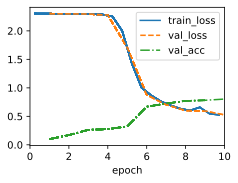

In [10]:
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)


## 議論

GoogLeNet の重要な特徴は、以前のバージョンよりも実際に計算コストが*安くなり*、同時に精度も向上していることです。これは、ネットワーク評価のコストとエラーの削減をトレードオフする、より慎重なネットワーク設計の始まりを示します。また、当時は完全に手動であったにもかかわらず、ネットワーク設計のハイパーパラメーターを使用したブロック レベルでの実験の始まりでもあります。ネットワーク構造探索の戦略を議論する際に、:numref: `sec_cnn-design`でこのトピックを再検討します。

次のセクションでは、ネットワークを大幅に改善できるようにする多くの設計上の選択肢 (バッチ正規化、残留接続、チャネル グループ化など) について説明します。今のところ、おそらく最初の真に現代的な CNN を実装したことを誇りに思ってよいでしょう。

## 演習
1. GoogLeNet は非常に成功したため、何度も反復されました。 GoogLeNet は何度か反復され、速度と精度が徐々に向上しました。いくつかを実装して実行してみてください。それらには次のものが含まれます。<ol><li> :numref: `sec_batch_norm`で後述するように、バッチ正規化レイヤー :cite: `Ioffe.Szegedy.2015`を追加します。
1.  :citet: `Szegedy.Vanhoucke.Ioffe.ea.2016`の説明に従って、Inception ブロック (畳み込みの幅、選択、順序) を調整します。
1.  :citet: `Szegedy.Vanhoucke.Ioffe.ea.2016`で説明されているように、モデルの正則化にラベル スムージングを使用します。
1.  :numref: `sec_resnet`で後述するように、残余接続 :cite: `Szegedy.Ioffe.Vanhoucke.ea.2017`を追加して、インセプション ブロックをさらに調整します。



[ディスカッション](https://discuss.d2l.ai/t/82)
